## Data Preparation

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [269]:
#Import data

df1 = pd.read_csv('Tokopedia Data Scrap 1 - Kopi.csv')
df2 = pd.read_csv('Tokopedia Data Scrap 2 - Kopi.csv')
df3 = pd.read_csv('Tokopedia Data Scrap 3 - Kopi.csv')
df4 = pd.read_csv('Tokopedia Data Scrap 4 - Kopi.csv')

df = pd.concat([df1, df2, df3, df4], ignore_index=True)
#df

In [270]:
#Add column and clean data

#Clean Duplicate
df = df.drop_duplicates()


#Remove Wrong Data
df = df[~df['Nama Produk'].str.contains('cupping tray|green bean|greenbean|mentah|mentah|bibit|500 ml|500ml|cair|benih', case=False)]


# Turn string to Float on Column 'Discount'
df['Diskon'] = df['Diskon'].str.replace('%', '').astype(float) / 100


#Cleaning kolom 'Lokasi'
df['Lokasi'] = df['Lokasi'].str.replace('-', 'Other')
df.loc[df['Toko'].str.contains('Tuang Coffee', case=False), 'Lokasi'] = 'Jakarta Selatan'
df.loc[df['Toko'].str.contains('Hatana Coffee', case=False), 'Lokasi'] = 'Medan'
df.loc[df['Toko'].str.contains('Kopi Luwak Official', case=False), 'Lokasi'] = 'Dilayani Tokopedia'
df.loc[df['Toko'].str.contains('Arutala Online Co.', case=False), 'Lokasi'] = 'Tangerang'
df.loc[df['Toko'].str.contains('Say Something Coffee', case=False), 'Lokasi'] = 'Jakarta Barat'



#Cleaning kolom 'Terjual'
df['Terjual'] = df['Terjual'].str.replace('Terjual ', '')


# Estimasi terjual berdasarkan kolom 'Terjual'
# Replace '+' with an empty string and 'rb+' with '000' in the 'Estimasi Terjual' column
df['Estimasi Terjual'] = df['Terjual'].str.replace('+', '', regex=True).str.replace(' rb+', '000', regex=True).str.replace('-', '0', regex=True)
# Convert the resulting strings to integers
df['Estimasi Terjual'] = pd.to_numeric(df['Estimasi Terjual'])


#Kolom Rating dari string ke angka
# df['Rating'] = df['Rating'].str.replace('-', '0', regex=True)
# df['Rating'] = pd.to_numeric(df['Rating'])


# Jenis Kopi (Arabika, Robusta, Blend)
keywords = ['arabika', 'arabica', 'robusta','liberika']
df['Jenis'] = df['Nama Produk'].str.extractall('(' + '|'.join(keywords) + ')', flags=re.IGNORECASE)\
                .groupby(level=0).apply(lambda x: 'Blend' if len(x) > 1 else x.iloc[0][0])
# df.loc[df['Nama Produk'].str.contains('|'.join(keywords), case=False), 'Jenis'] = 'Blend'
# df['Jenis'] = df['Nama Produk'].str.extract(r'(' + '|'.join(keywords) + ')', flags=re.IGNORECASE, expand=False)
df['Jenis'] = df['Jenis'].fillna('Other')
df.loc[df['Nama Produk'].str.contains('blend|mix', case=False), 'Jenis'] = 'Blend'
df['Jenis'] = df['Jenis'].str.capitalize().str.replace('Arabica', 'Arabika')


# Proses kopi (Natural, Full Washed, dll)
df['Proses'] = df['Nama Produk'].str.extract(r'(luwak|natural|wine|wash|full washed|fullwash|semi wash|semiwash|semi washed|honey)', flags=re.IGNORECASE, expand=False)
df['Proses'] = df['Proses'].fillna('Other')
df['Proses'] = df['Proses'].apply(lambda x: " ".join(word.capitalize() for word in x.split()))
df['Proses'] = df['Proses'].str.replace('Full Washed', 'Wash').str.replace('Fullwash', 'Wash')


# Origin kopi
origin_keywords = r'suwarnadwipa|sumatra|gayo|sidikalang|lintong|mandailing|kerinci|solok|pagar alam|pagaralam|semendo|lampung|sumsel|jambi|meranti|bengkulu|halu|cibunar|mukapayung|java|preanger|sumedang|sunda|kamojang|ciwidey|rancabali|manglayang|malabar|papandayan|semeru|garut|puntang|ijen|temanggung|dampit|senduro|arjuno|toraja|mamasa|latimojong|bali|kintamani|flores|papua|wamena|kilimanjaro tanzania|kenya kirinyaga|sakicha|Colombia El Diviso|yirgacheffe|hawaii|congo|guatemala|brazil|honduras|india|vietnam'


df['Origin'] = df['Nama Produk'].str.extract(rf'({origin_keywords})', flags=re.IGNORECASE, expand=False).fillna('Other')
df.loc[df['Nama Produk'].str.contains('blend', case=False), 'Origin'] = 'Blend'
df.loc[df['Nama Produk'].str.contains('Tuang Coffee'), 'Origin'] = 'Flores'
df['Origin'] = df['Origin'].apply(lambda x: x.capitalize().replace('-', 'Other'))

# Origin Negara kopi (Lokal/Int)
def get_negara(origin):
    lokal_keywords = r'suwarnadwipa|sumatra|gayo|sidikalang|lintong|mandailing|kerinci|solok|pagar alam|pagaralam|semendo|lampung|sumsel|jambi|meranti|bengkulu|halu|cibunar|mukapayung|java|preanger|sumedang|sunda|kamojang|ciwidey|rancabali|manglayang|malabar|papandayan|semeru|garut|puntang|ijen|temanggung|dampit|senduro|arjuno|toraja|mamasa|latimojong|bali|kintamani|flores|papua|wamena|'
    if any(re.findall(lokal_keywords, origin.lower())):
        return 'Lokal'
    elif any(country in origin.lower() for country in ['kilimanjaro tanzania', 'kenya kirinyaga', 'sakicha', 'colombia el diviso', 'yirgacheffe', 'hawaii', 'congo', 'guatemala', 'brazil', 'honduras', 'india', 'vietnam']):
        return 'Internasional'
    else:
        return 'Other'
# Kolom Negara
df['Negara'] = df['Origin'].apply(get_negara)  
    

# Jumlah gramasi kopi (100 gr, 150 gr, 200 gr, 250 gr, 1 kg, 10 gr)
df['Jumlah gram'] = df['Nama Produk'].str.extract(r'(100gr|100 gr|150gr|150 gr|200gr|200 gr|250gr|250 gr|500gr|500 gr|10 gr|10gr|1 kg|1kg)', flags=re.IGNORECASE, expand=False)
df['Jumlah gram'] = df['Jumlah gram'].fillna('Other')
df['Jumlah gram'] = df['Jumlah gram'].apply(lambda x: " ".join(word.capitalize() for word in x.split()))
df['Jumlah gram'] = df['Jumlah gram'].replace({'1 Kg': '1000', '1kg': '1000', '10 Gr': '10', '200 Gr': '200', '250 Gr': '250','200gr':'200', '500 Gr':'500', '100gr':'100', '250gr':'250', '100 Gr':'100', '500gr':'500', '150 Gr':'150', '780 Gr':'780', '380 Gr':'380'})

       
# # Harga
# Define the regular expression pattern to match
pattern = r"\D"
# Remove non-numeric characters from the "harga" column
df['Harga'] = df['Harga'].str.replace(pattern, "", regex=True)
# Convert the resulting strings to integers
df['Harga'] = pd.to_numeric(df['Harga'])


# # Harga Sebelum Diskon
# Define the regular expression pattern to match
pattern = r"\D"
# Remove non-numeric characters from the "harga" column
df['Harga Sebelum Diskon'] = df['Harga Sebelum Diskon'].str.replace(pattern, "", regex=True)
# Convert the resulting strings to integers
df['Harga Sebelum Diskon'] = pd.to_numeric(df['Harga Sebelum Diskon'])

In [271]:
# df.head(5)

In [272]:
# Cek Nilai Unik pada 'Kolom'
# df['Toko'].unique()

In [273]:
# Urutan berdasarkan 'Kolom'
# df.sort_values('Estimasi Terjual', ascending=False).head(5)

In [315]:
# Cek pada 'Kolom' apakah mengandung 'Value' tertentu
# df[df['Nama Produk'].str.contains('green', case=False)]

In [275]:
# Mengubah nilai 'Kolom' menjadi list
# df[df['Nama Produk'].str.contains('excelsa', case=False)]['Nama Produk'].values.tolist()

In [277]:
# df.to_csv('Tokopedia - Kopi complete.csv', index=False)

## Data Analysis and Visualization

#### A. Toko dengan Penjualan Estimasi Terbanyak 

In [278]:
Penjualan_toko = df.groupby('Toko').agg({'Estimasi Terjual': 'sum', 'Rating': 'mean'})
Penjualan_toko = Penjualan_toko.sort_values('Estimasi Terjual', ascending=False)
Penjualan_toko

,Estimasi Terjual,Rating
Toko,,
Tuang Coffee,87500,4.973333
Arutala Online Co.,72978,4.912000
Tanamera Coffee,29750,4.992857
Sakha Coffee Roastery,20060,4.967857
The Cold Crafters,20000,4.900000
...,...,...
ETNIKAN,0,0.000000
Klethikan_JengAyu,0,0.000000
Tukang Gudang,0,0.000000


In [279]:
Penjualan_toko.to_csv('1. Penjualan Toko.csv', index=False)

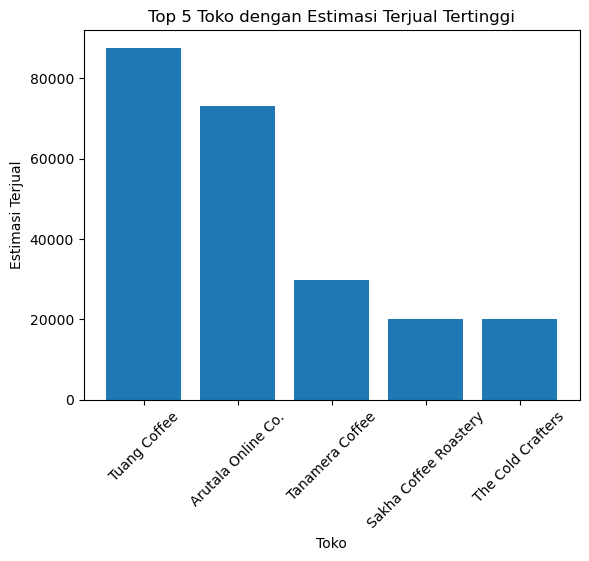

In [280]:
# Create a bar chart
# get top 5 rows
top_5pt = Penjualan_toko.iloc[:5]

# create bar plot
plt.bar(top_5pt.index, top_5pt['Estimasi Terjual'])

# set axis labels and title
plt.xlabel('Toko')
plt.ylabel('Estimasi Terjual')
plt.title('Top 5 Toko dengan Estimasi Terjual Tertinggi')
plt.xticks(rotation=45)

# display plot
plt.show()

#### B. Daerah dengan Penjualan Estimasi Terbanyak 

In [281]:
Penjualan_daerah = df.groupby('Lokasi').agg({'Estimasi Terjual': 'sum', 'Rating': 'mean'})
Penjualan_daerah = Penjualan_daerah.sort_values('Estimasi Terjual', ascending=False)
Penjualan_daerah

,Estimasi Terjual,Rating
Lokasi,,
Jakarta Selatan,101558,4.927027
Tangerang,79167,4.876923
Jakarta Barat,42202,4.856250
Tangerang Selatan,34585,4.988000
Bandung,23311,4.826316
Jakarta Utara,23025,4.585714
Bekasi,22527,4.968571
Kab. Tangerang,22505,4.450000
Dilayani Tokopedia,19930,4.914286


In [282]:
Penjualan_daerah.to_csv('2. Penjualan Daerah.csv', index=False)

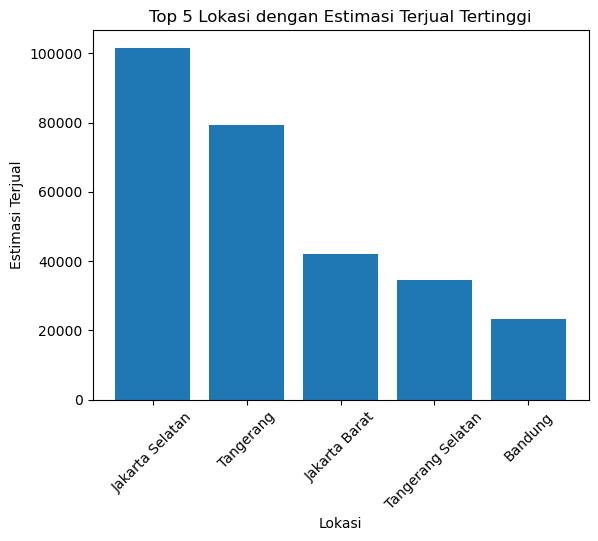

In [283]:
# Create a bar chart
# get top 5 rows
top_5pd = Penjualan_daerah.iloc[:5]

# create bar plot
plt.bar(top_5pd.index, top_5pd['Estimasi Terjual'])

# set axis labels and title
plt.xlabel('Lokasi')
plt.ylabel('Estimasi Terjual')
plt.title('Top 5 Lokasi dengan Estimasi Terjual Tertinggi')
plt.xticks(rotation=45)

# display plot
plt.show()

#### C. Origin, Negara dan Proses Paska Panen dengan Penjualan Estimasi Terbanyak

In [284]:
Penjualan_per_Origin = df.groupby('Origin').agg({'Estimasi Terjual': 'sum'})
Penjualan_per_Origin = Penjualan_per_Origin.sort_values('Estimasi Terjual', ascending=False)
Penjualan_per_Origin

,Estimasi Terjual
Origin,
Other,125978
Flores,102241
Blend,41435
Toraja,41339
Gayo,40540
Dampit,19700
Temanggung,18981
Bali,18104
Lampung,16459


In [285]:
Penjualan_per_Origin.to_csv('3. Penjualan Origin.csv', index=False)

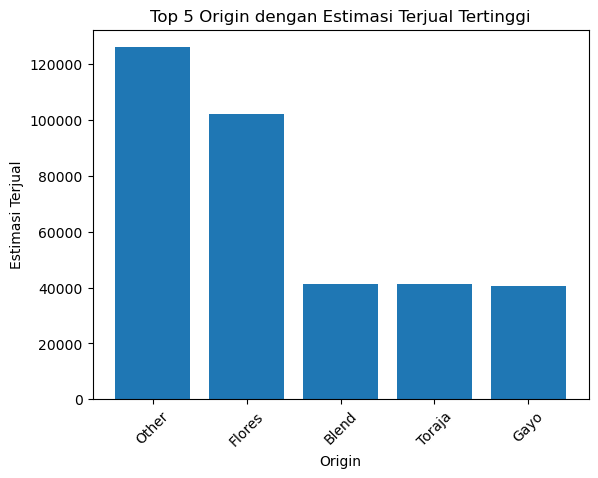

In [286]:
# Create a bar chart
# get top 5 rows
top_5po = Penjualan_per_Origin.iloc[:5]

# create bar plot
plt.bar(top_5po.index, top_5po['Estimasi Terjual'])

# set axis labels and title
plt.xlabel('Origin')
plt.ylabel('Estimasi Terjual')
plt.title('Top 5 Origin dengan Estimasi Terjual Tertinggi')
plt.xticks(rotation=45)

# display plot
plt.show()

In [287]:
#Perbandingan perkiraan penjualan kopi lokal dan interansional

In [288]:
Penjualan_per_Negara = df.groupby('Negara').agg({'Estimasi Terjual': 'sum'})
Penjualan_per_Negara = Penjualan_per_Negara.sort_values('Estimasi Terjual', ascending=False)
Penjualan_per_Negara = Penjualan_per_Negara.reset_index()
Penjualan_per_Negara

,Negara,Estimasi Terjual
0,Lokal,307475
1,Other,167413
2,Internasional,9219


In [289]:
Penjualan_per_Negara.to_csv('4. Penjualan Negara.csv', index=False)

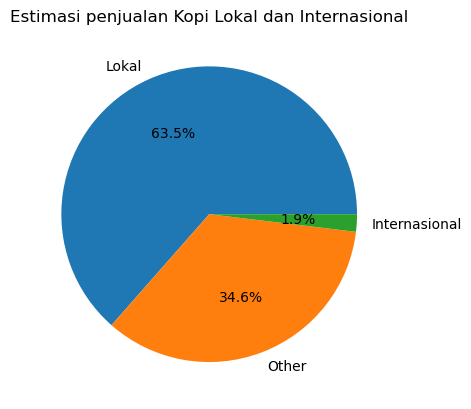

In [290]:
labels = Penjualan_per_Negara['Negara']
sizes = Penjualan_per_Negara['Estimasi Terjual']

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Estimasi penjualan Kopi Lokal dan Internasional')

# Show the chart
plt.show()

In [291]:
Penjualan_per_Proses = df.groupby('Proses').agg({'Estimasi Terjual': 'sum'})
Penjualan_per_Proses = Penjualan_per_Proses.sort_values('Estimasi Terjual', ascending=False)
#Penjualan_per_Proses = [row for row in Penjualan_per_Proses if row[0] != 'Other']
Penjualan_per_Proses

,Estimasi Terjual
Proses,
Other,402770
Natural,41882
Wash,29780
Luwak,4951
Wine,4332
Honey,392


In [292]:
Penjualan_per_Proses.to_csv('5. Penjualan Per Proses.csv', index=False)

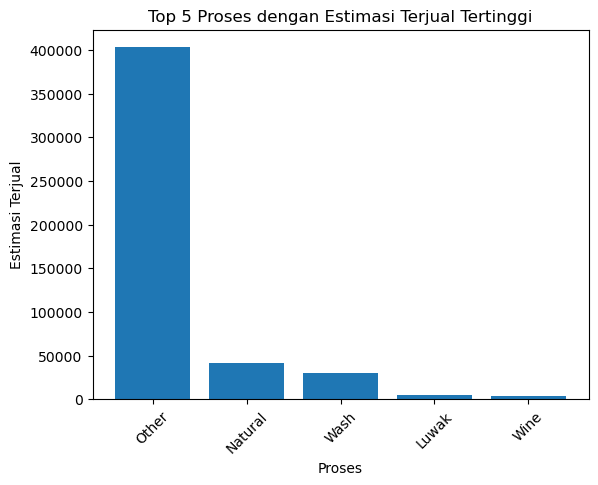

In [293]:
# Create a bar chart
# get top 5 rows
top_5p = Penjualan_per_Proses.iloc[:5]

# create bar plot
plt.bar(top_5p.index, top_5p['Estimasi Terjual'])

# set axis labels and title
plt.xlabel('Proses')
plt.ylabel('Estimasi Terjual')
plt.title('Top 5 Proses dengan Estimasi Terjual Tertinggi')
plt.xticks(rotation=45)

# display plot
plt.show()

#### D. Penjualan Estimasi Arabika, Robusta, Ekselsa

In [294]:
Penjualan_jenis_kopi = df
Penjualan_jenis_kopi['Jenis'] = Penjualan_jenis_kopi['Jenis'].replace(['Liberika', 'Excelsa'], 'Other')
Penjualan_jenis_kopi = Penjualan_jenis_kopi.groupby('Jenis').agg({'Estimasi Terjual': 'sum'})
Penjualan_jenis_kopi = Penjualan_jenis_kopi.sort_values('Estimasi Terjual', ascending=False)
Penjualan_jenis_kopi = Penjualan_jenis_kopi.reset_index()
Penjualan_jenis_kopi

,Jenis,Estimasi Terjual
0,Robusta,244170
1,Blend,109472
2,Arabika,100071
3,Other,30394


In [295]:
Penjualan_jenis_kopi.to_csv('6. Penjualan Per Jenis.csv', index=False)

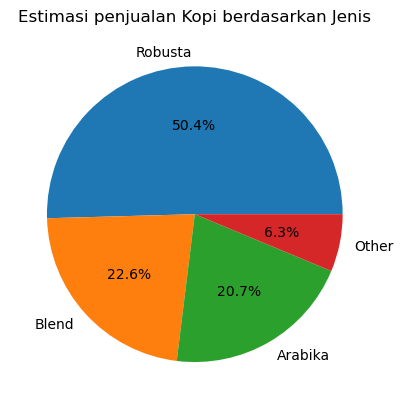

In [296]:
labels = Penjualan_jenis_kopi['Jenis']
sizes = Penjualan_jenis_kopi['Estimasi Terjual']

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Estimasi penjualan Kopi berdasarkan Jenis')

# Show the chart
plt.show()

#### E. Jenis Jumlah Gram Kemasan dengan Penjualan Estimasi Tertinggi

In [297]:
Penjualan_jml_gr = df.groupby('Jumlah gram').agg({'Estimasi Terjual': 'sum'})
Penjualan_jml_gr = Penjualan_jml_gr.sort_values('Estimasi Terjual', ascending=False)
Penjualan_jml_gr

,Estimasi Terjual
Jumlah gram,
Other,157356
1000,133687
250,118383
200,28665
500,27550
100,14166
150,3200
10,1100


In [298]:
Penjualan_jml_gr.to_csv('7. Penjualan Per gram.csv', index=False)

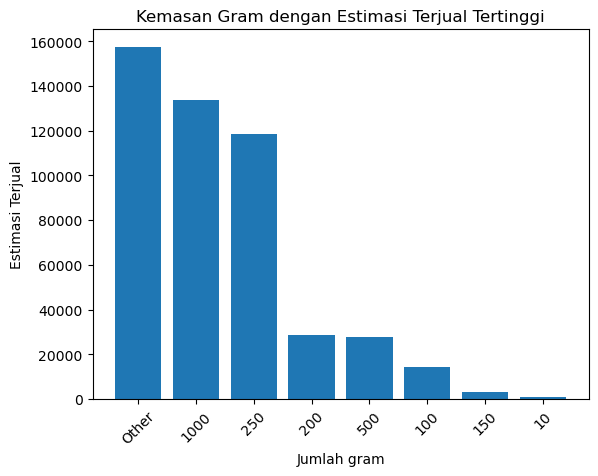

In [299]:
# Create a bar chart
# create bar plot
plt.bar(Penjualan_jml_gr.index, Penjualan_jml_gr['Estimasi Terjual'])

# set axis labels and title
plt.xlabel('Jumlah gram')
plt.ylabel('Estimasi Terjual')
plt.title('Kemasan Gram dengan Estimasi Terjual Tertinggi')
plt.xticks(rotation=45)

# display plot
plt.show()

#### F. Korelasi harga dan terjual 

In [300]:
Harga_dan_Terjual = df.loc[:, ['Nama Produk','Harga', 'Estimasi Terjual']] 
Harga_dan_Terjual = Harga_dan_Terjual.sort_values('Harga', ascending=False)
Harga_dan_Terjual

,Nama Produk,Harga,Estimasi Terjual
19169,Kona Coffee Hawaii 100% Peaberry Medium Roast ...,750000,5
43573,Kopi Luwak Authentic Arabica 150 Gr,744610,100
4850,Kopi Arabika Ethiopia Yirgacheffe 1 KG Special...,502000,50
30,Kopi Arabika Tanamera Coffee Premium Blend 1Kg,463000,750
48,Kopi Arabika Tanamera Coffee Sumatera: Mandail...,462000,500
...,...,...,...
76,Robeans Self Drip Coffee | Kopi Tetes Arabika ...,9000,250
22858,Kopi Drip Robusta Mandailing dengan Filter Bag...,8000,100
22844,Ka.Mu kopi Robusta Pagar Alam,6000,40
32616,Ka.Mu kopi Robusta Pagar Alam - Plastik bening...,6000,40


In [301]:
Harga_dan_Terjual.to_csv('8. Harga dan Terjual.csv', index=False)

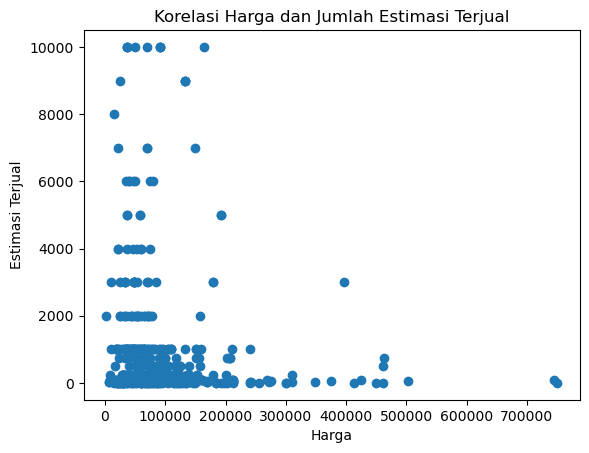

In [302]:
# create scatter plot
plt.scatter(Harga_dan_Terjual['Harga'], Harga_dan_Terjual['Estimasi Terjual'])

# set axis labels and title
plt.xlabel('Harga')
plt.ylabel('Estimasi Terjual')
plt.title('Korelasi Harga dan Jumlah Estimasi Terjual')

# display plot
plt.show()

#### 7. Korelasi rating dan terjual 

In [303]:
Rating_dan_Terjual = df.loc[:, ['Nama Produk','Rating', 'Estimasi Terjual']]
Rating_dan_Terjual = Rating_dan_Terjual.sort_values('Estimasi Terjual', ascending=False)
Rating_dan_Terjual

,Nama Produk,Rating,Estimasi Terjual
6233,Roasted Bean Premium Robusta Natural Tuang Cof...,5.0,10000
43591,Biji Kopi 100% Full Arabica Mandheling Roasted...,4.9,10000
22900,Kopi Java Robusta 900g - Roastedbean (biji san...,4.9,10000
9793,Roasted Bean Premium Robusta Natural Tuang Cof...,5.0,10000
23407,ARUTALA Kopi Toraja Rantebua Robusta Coffee In...,4.9,10000
...,...,...,...
43631,Bubuk Kopi Putih Liberika / Nangka 1kg (100% O...,0.0,0
43650,BIJI KOPI LIBERIKA MIX ARABIKA ROASTING 500GRA...,0.0,0
43649,Kopi Liberika Kopi Bedhag Djemberan 100 Gram,0.0,0
1097,Kopi Teras - Kopi arabika 250 gram,0.0,0


In [304]:
Rating_dan_Terjual.to_csv('9. Rating dan Terjual.csv', index=False)

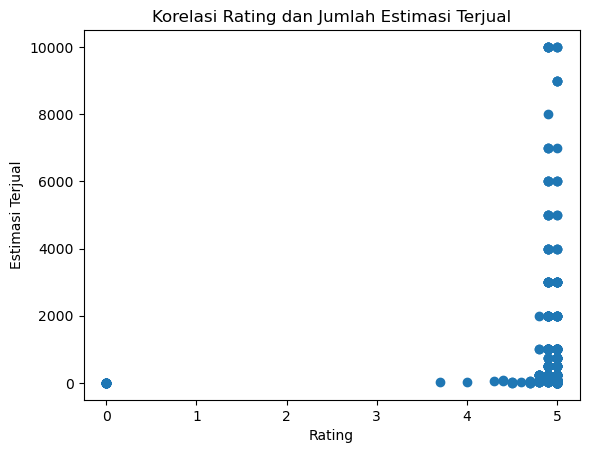

In [305]:
# create scatter plot
plt.scatter(Rating_dan_Terjual['Rating'], Rating_dan_Terjual['Estimasi Terjual'])

# set axis labels and title
plt.xlabel('Rating')
plt.ylabel('Estimasi Terjual')
plt.title('Korelasi Rating dan Jumlah Estimasi Terjual')

# display plot
plt.show()

#### G. Berapa Kelompok Harga dengan Penjualan Estimasi Tertinggi

In [306]:
Harga= df.loc[:, ['Nama Produk','Harga', 'Estimasi Terjual']] 

# Define a function to map ages to categories
def harga_to_category(Harga):
    if Harga < 50000:
        return '<50000'
    elif 50000 < Harga < 100000:
        return '50000-100000'
    elif 100000 < Harga < 150000:
        return '100000-150000'
    elif 150000 < Harga < 200000:
        return '150000-200000'
    elif 200000 < Harga < 250000:
        return '200000-250000'
    elif 250000 < Harga < 300000:
        return '250000-300000'
    elif 300000 < Harga < 350000:
        return '300000-350000'
    elif 350000 < Harga < 400000:
        return '350000-400000'
    elif 400000 < Harga < 450000:
        return '400000-450000'
    elif 450000 < Harga < 500000:
        return '450000-500000'
    elif 500000 < Harga < 550000:
        return '500000-550000'
    elif 550000 < Harga < 600000:
        return '550000-600000'
    elif 600000 < Harga < 650000:
        return '600000-650000'
    elif 650000 < Harga < 700000:
        return '650000-700000'
    elif 700000 < Harga < 750000:
        return '700000-750000'
    elif 750000 < Harga < 800000:
        return '750000-800000'
    else:
        return '>800000'

# Create a new column 'category' based on 'age'
Harga['Kategori_Harga'] = df['Harga'].apply(harga_to_category)
#harga = harga.sort_values('Kategori_Harga', ascending=False)
Harga


,Nama Produk,Harga,Estimasi Terjual,Kategori_Harga
0,Kopi Arabika Aceh Gayo - Roasted Bean - 200 Gr...,46000,250,<50000
1,Kopi Arabika Aceh Gayo 1 KG - Commercial Grade...,160000,1000,150000-200000
2,Kopi Robusta Aceh Gayo - Roasted Bean - 1 KG -...,104500,500,100000-150000
3,Kopi Arabika Ethiopia Yirgacheffe 200 gram Spe...,158000,500,150000-200000
4,Kopi [Biji/Bubuk] Arabika Aceh Gayo WINE Kuali...,78750,100,50000-100000
...,...,...,...,...
44567,KAPAL API Special Silver 2 X 380 gr,40000,500,<50000
44674,Kopi Bubuk Kapal Tanker New - 780 Gr,33600,3000,<50000
45148,OZONITE MANTESA 84H | FILTER COFFEE | SPECIALT...,60000,70,50000-100000
45149,Kopiz Arabica Lembah Kerinci Raya,130000,0,100000-150000


In [307]:
Harga_sum = Harga.groupby('Kategori_Harga').agg({'Estimasi Terjual': 'sum'})
Harga_sum = Harga_sum.reset_index()
Harga_sum

,Kategori_Harga,Estimasi Terjual
0,100000-150000,43658
1,150000-200000,41411
2,200000-250000,5461
3,250000-300000,206
4,300000-350000,299
5,350000-400000,3060
6,400000-450000,106
7,450000-500000,1259
8,50000-100000,177688
9,500000-550000,50


In [308]:
# Define a function to map ages to categories
def order(Kategori_Harga):
    if Kategori_Harga == '<50000':
        return 1
    elif Kategori_Harga == '50000-100000':    
        return 2
    elif Kategori_Harga == '100000-150000':
        return 3
    elif Kategori_Harga == '150000-200000':
        return 4
    elif Kategori_Harga == '200000-250000':
        return 5
    elif Kategori_Harga == '250000-300000':    
        return 6
    elif Kategori_Harga == '300000-350000':       
        return 7
    elif Kategori_Harga == '350000-400000':  
        return 8
    elif Kategori_Harga == '400000-450000':    
        return 9
    elif Kategori_Harga == '450000-500000':
        return 10
    elif Kategori_Harga == '500000-550000':
        return 11
    elif Kategori_Harga == '550000-600000':
        return 12
    elif Kategori_Harga == '600000-650000':
        return 13
    elif Kategori_Harga == '650000-700000':
        return 14
    elif Kategori_Harga == '700000-750000':
        return 15
    elif Kategori_Harga == '750000-800000':
        return 16
    elif Kategori_Harga == '>800000':
        return 17 

# Create a new column 'category' based on 'age'
Harga_sum['Urutan'] = Harga_sum['Kategori_Harga'].apply(order)
Harga_sum = Harga_sum.sort_values('Urutan', ascending=True)
Harga_sum

,Kategori_Harga,Estimasi Terjual,Urutan
11,<50000,197550,1
8,50000-100000,177688,2
0,100000-150000,43658,3
1,150000-200000,41411,4
2,200000-250000,5461,5
3,250000-300000,206,6
4,300000-350000,299,7
5,350000-400000,3060,8
6,400000-450000,106,9
7,450000-500000,1259,10


In [309]:
Harga_sum.to_csv('10. Penjualan per rentang harga.csv', index=False)

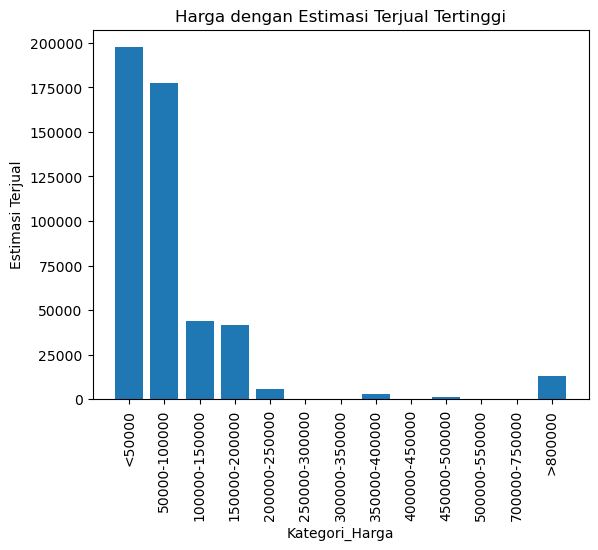

In [310]:
# create bar plot
plt.bar(Harga_sum['Kategori_Harga'], Harga_sum['Estimasi Terjual'])

# set axis labels and title
plt.xlabel('Kategori_Harga')
plt.ylabel('Estimasi Terjual')
plt.title('Harga dengan Estimasi Terjual Tertinggi')
plt.xticks(rotation=90)

# display plot
plt.show()

#### H. Korelasi Diskon dan Estimasi Penjualan

In [311]:
Diskon_dan_penjualan = df.loc[:, ['Nama Produk','Diskon', 'Estimasi Terjual']]
Diskon_dan_penjualan = Diskon_dan_penjualan.sort_values('Estimasi Terjual', ascending=False)
Diskon_dan_penjualan

,Nama Produk,Diskon,Estimasi Terjual
6233,Roasted Bean Premium Robusta Natural Tuang Cof...,0.17,10000
43591,Biji Kopi 100% Full Arabica Mandheling Roasted...,0.00,10000
22900,Kopi Java Robusta 900g - Roastedbean (biji san...,0.00,10000
9793,Roasted Bean Premium Robusta Natural Tuang Cof...,0.17,10000
23407,ARUTALA Kopi Toraja Rantebua Robusta Coffee In...,0.20,10000
...,...,...,...
43631,Bubuk Kopi Putih Liberika / Nangka 1kg (100% O...,0.00,0
43650,BIJI KOPI LIBERIKA MIX ARABIKA ROASTING 500GRA...,0.00,0
43649,Kopi Liberika Kopi Bedhag Djemberan 100 Gram,0.00,0
1097,Kopi Teras - Kopi arabika 250 gram,0.00,0


In [312]:
Diskon_dan_penjualan.to_csv('11. Diskon dan Terjual.csv', index=False)

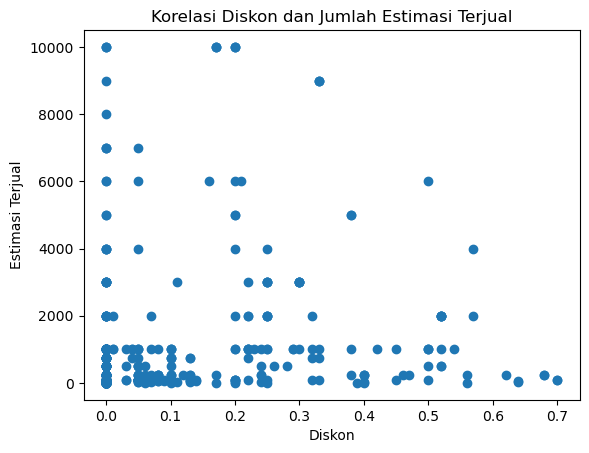

In [313]:
# create scatter plot
plt.scatter(Diskon_dan_penjualan['Diskon'], Diskon_dan_penjualan['Estimasi Terjual'])

# set axis labels and title
plt.xlabel('Diskon')
plt.ylabel('Estimasi Terjual')
plt.title('Korelasi Diskon dan Jumlah Estimasi Terjual')

# display plot
plt.show()